# Tutorial 2: Fields and Operators

**Overview:** This tutorials covers the basics of setting up and interacting with field and operator objects in Dedalus.
Dedalus uses field and operator abstractions to implement a symbolic algebra system for representing mathematical expressions and PDEs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
figkw = {'figsize':(6,4), 'dpi':100}

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2.1: Fields

### Creating a field

Field objects in Dedalus represent scalar-valued fields defined over a domain.
A field can be directly instantiated from the `Field` class by passing a domain object, or using the `domain.new_field` method.
Let's set up a 2D domain and build a field:

In [3]:
xbasis = de.Fourier('x', 64, interval=(-np.pi, np.pi), dealias=3/2)
ybasis = de.Chebyshev('y', 64, interval=(-1, 1), dealias=3/2)
domain = de.Domain([xbasis, ybasis], grid_dtype=np.float64)
f = domain.new_field(name='f')

We also gave the field a name -- something which is automatically done for the state fields when solving a PDE in Dedalus (we'll see more about this in the next notebook), but we've just done it manually, for now.

### Manipulating field data

Field objects have a variety of methods for transforming their data between different layouts (i.e. grid and coefficient space, and all the layouts in-between). 
The `layout` attribute of each field points to the layout object describing its current transform and distribution state.
We can see that fields are instantiated in coefficient space:

In [4]:
f.layout.grid_space

array([False, False])

Field data can be assigned and retrieved in any layout by indexing a field with that layout object.
In most cases, mixed layouts aren't needed, and it's just the full grid and full coefficient data that are most useful to interact with.
These layouts can be easily accessed using `'g'` and `'c'` keys as shortcuts.

When accessing field data in parallel, each process manipulates just the local data of the globally distributed dataset.
We can therefore easily set a field's grid data in a parallel-safe fashion by using the local grids provided by the domain object:

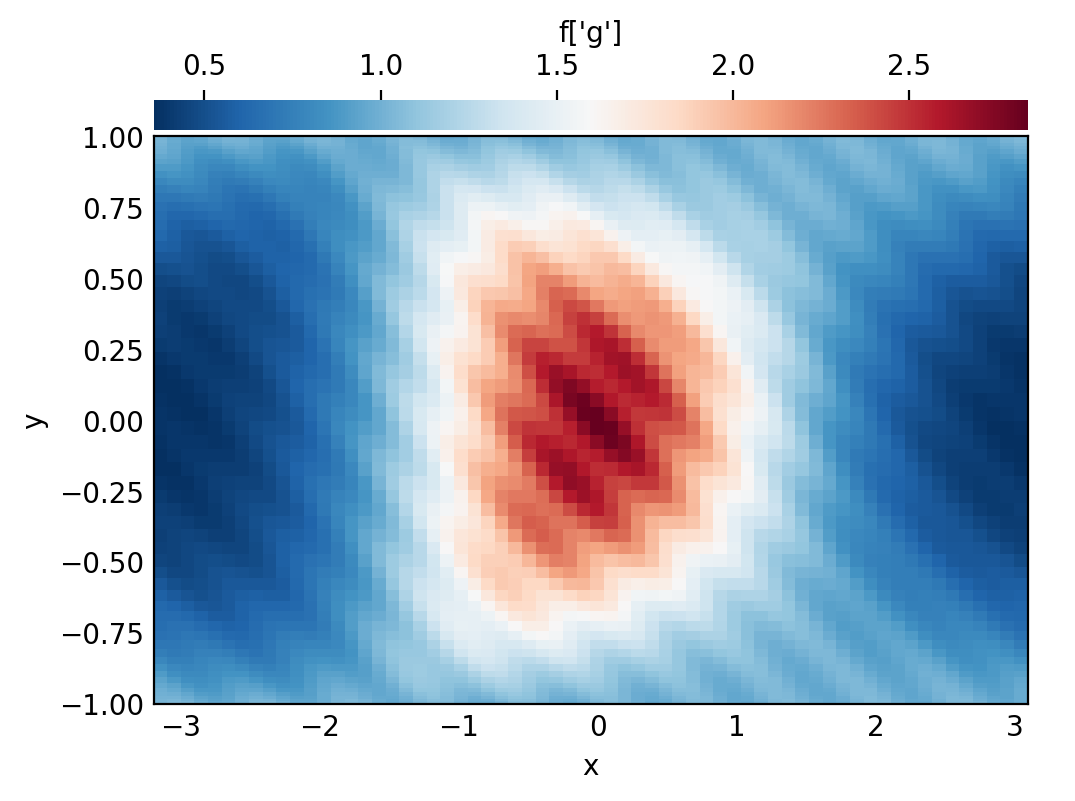

In [5]:
x, y = domain.grids(scales=1)
f.set_scales(1)
f['g'] = np.exp((1-y**2)*np.cos(x+np.cos(x)*y**2)) * (1 + 0.05*np.cos(10*(x+2*y)))

# Plot grid values
plot_bot_2d(f, figkw=figkw, title="f['g']");

We can convert a field to spectral coefficients by requesting the field's data in coefficient space.
This internally triggers an in-place multidimensional spectral transform on the field's data.

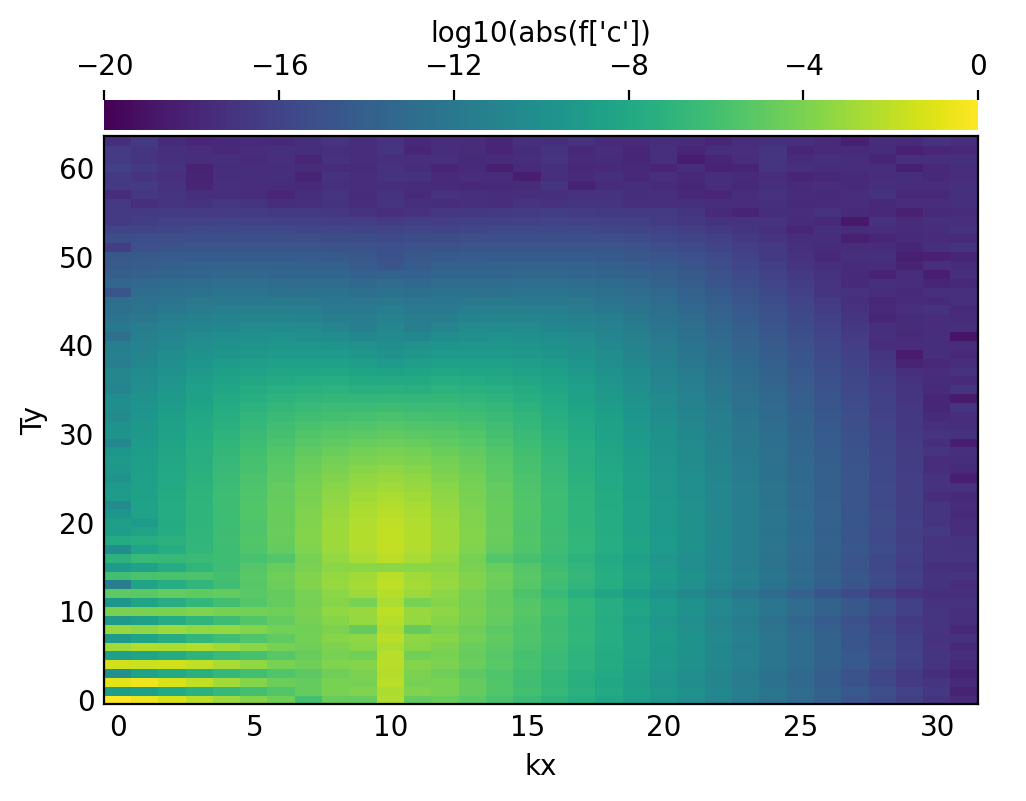

In [6]:
f['c']

# Plot log magnitude of spectral coefficients
log_mag = lambda xmesh, ymesh, data: (xmesh, ymesh, np.log10(np.abs(data)))
plot_bot_2d(f, func=log_mag, clim=(-20, 0), cmap='viridis', title="log10(abs(f['c'])", figkw=figkw);

Examining the spectral coefficients of fields is very useful, since the amplitude of the highest modes indicate the truncation errors in the spectral discretizations of fields.
If these modes are small, like here, then we know the field is well-resolved.

### Field scale factors

The `set_scales` method on a field is used to change the scaling factors used when transforming the field's data into grid space.
When setting a field's data using grid arrays, shape errors will result if there is a mismatch between the field and grid's scale factors.

Large scale factors can be used to interpolate the field data onto a high-resolution grid, while small scale factors can be used to view a lower-resolution grid representation of a field.
**Beware:** using scale factors less than 1 will result in a loss of data when transforming to grid space.

Let's take a look at a high-resolution sampling of our field, by increasing the scales.

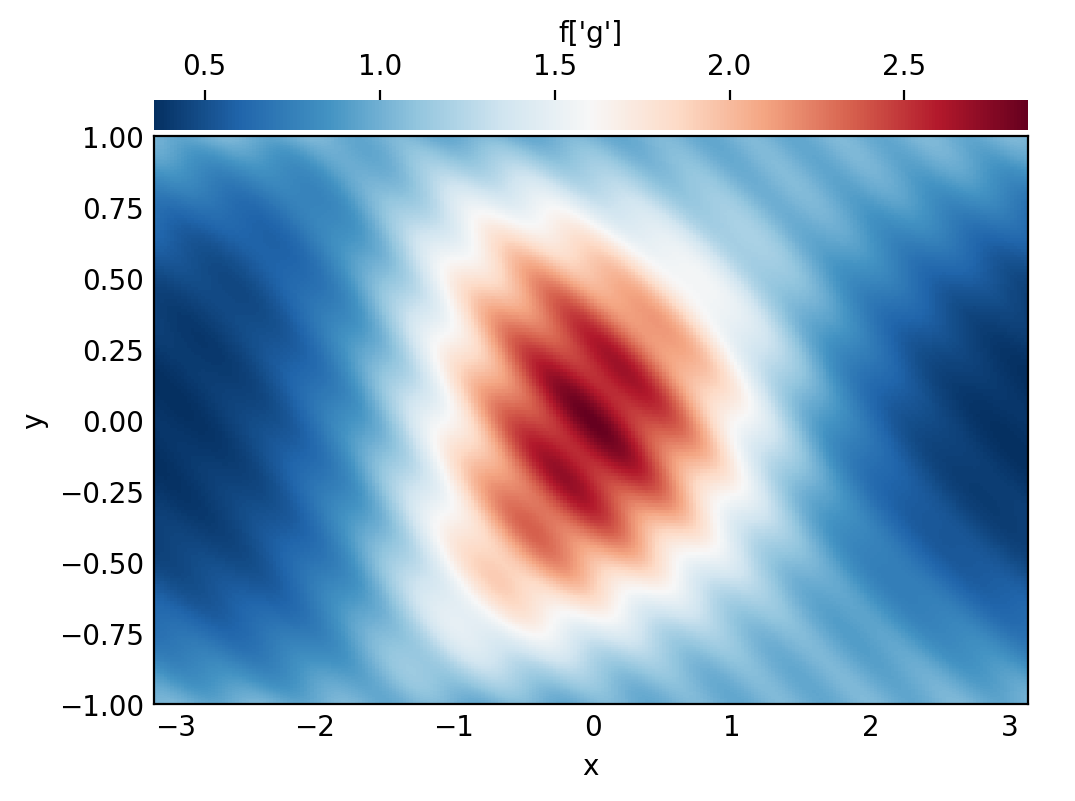

In [7]:
f.set_scales(4)

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

## 2.2: Operators

### Arithmetic with fields

Mathematical operations on fields, including arithmetic, differentiation, integration, and interpolation, are represented by `Operator` classes.
An instance of an operator class represents a specific mathematical expression, and provides an interface for the deferred evaluation of that expression with respect to it's potentially evolving arguments.

Arithmetic operations between fields, or fields and scalars, are produced simply using Python's infix operators for arithmetic.
Let's start with a simple affine transformation of our field:

In [8]:
g_op = 1 - 2*f
print(g_op)

1 + (-1*(2*f))


The object we get is not another field, but an operator object representing the addition of 1 to the multiplication of -1, 2, and our field.
To actually compute this operation, we use the `evaluate` method, which returns a new field with the result.
The dealias scale factors set during basis instantiation are used for the evaluation of all operators.

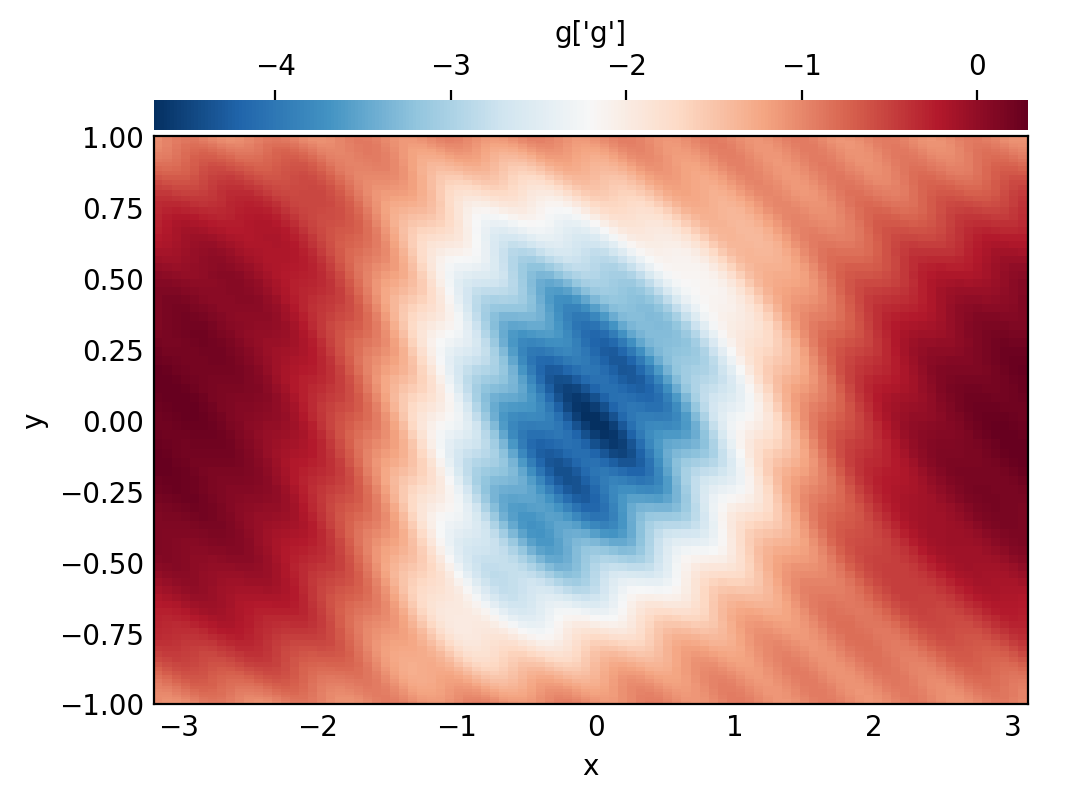

In [9]:
g = g_op.evaluate()

# Plot grid values
g['g']
plot_bot_2d(g, title="g['g']", figkw=figkw);

### Building expressions

Operator instances can be passed as arguments to other operators, building trees that represent more complicated expressions:

In [10]:
h_op = 1 / np.cosh(g_op + 2.5)
print(h_op)

cosh((1 + (-1*(2*f))) + 2.5)**-1


Reading these signatures can be a little cumbersome, but we can plot the operator's structure using a helper from `dedalus.tools`:

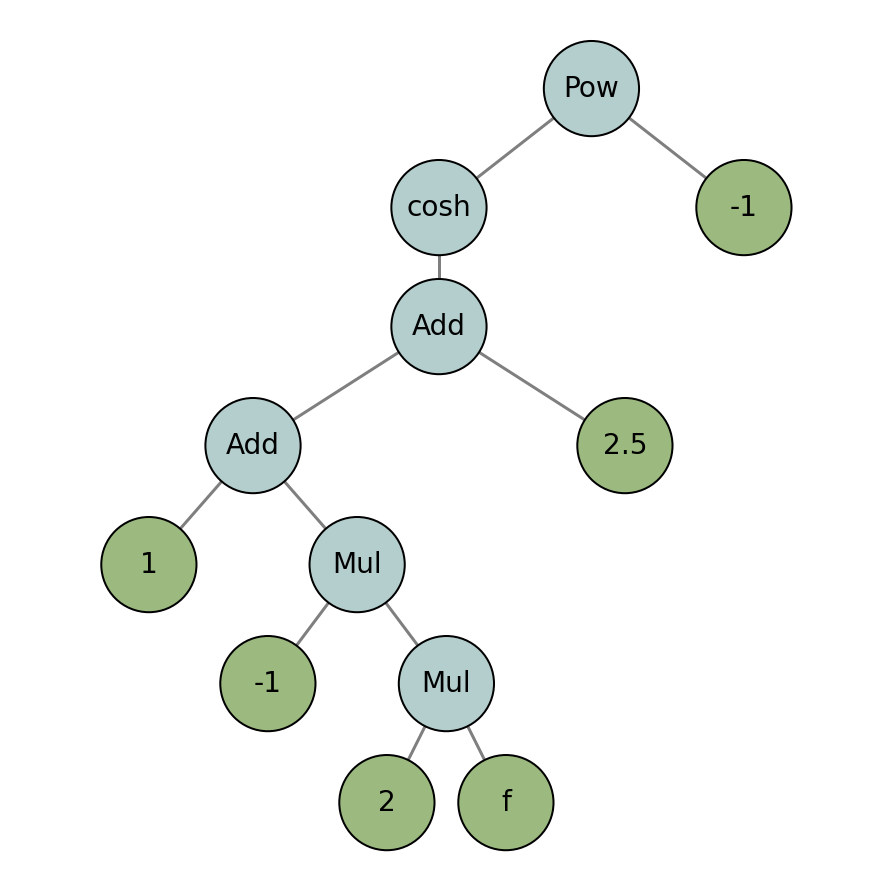

In [11]:
from dedalus.tools.plot_op import plot_operator
plot_operator(h_op, figsize=6, fontsize=14, opsize=0.4)

And evaluating it:

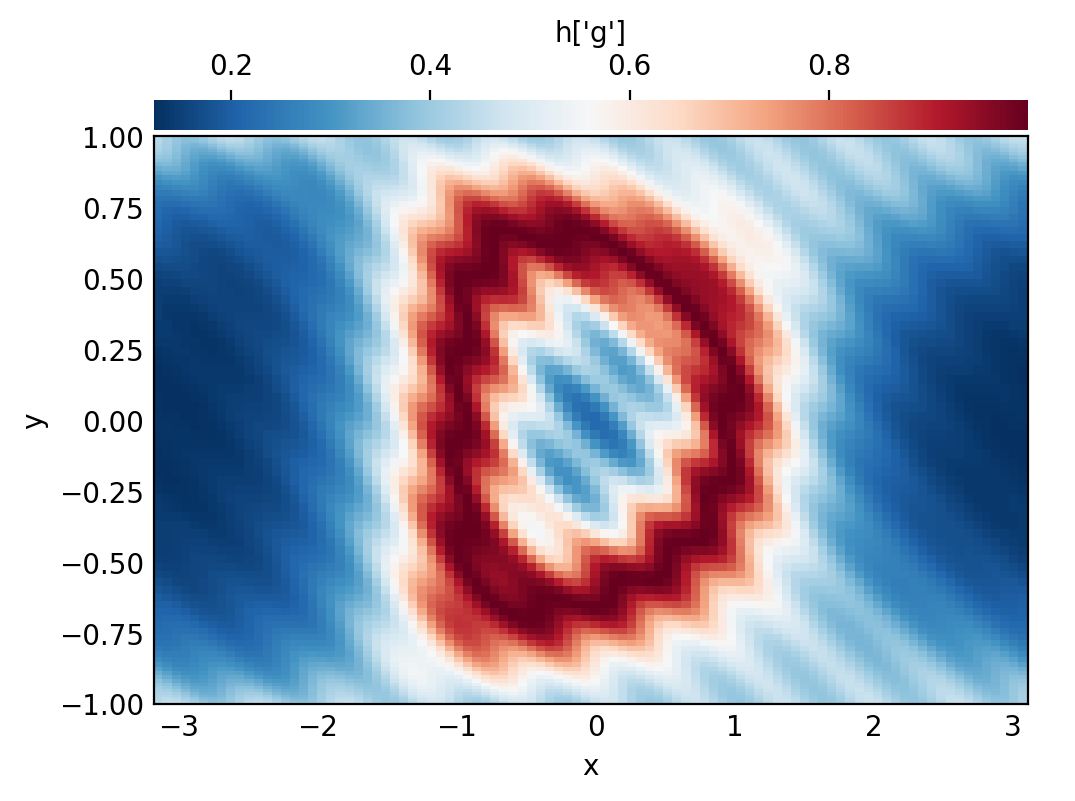

In [12]:
h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

### Deferred evaluation

A key point is that the operator objects symbolically represent an operation on the field arguments, and are evaluated using deferred evaluation.
If we change the data of the field arguments and re-evaluate an operator, we get a new result.

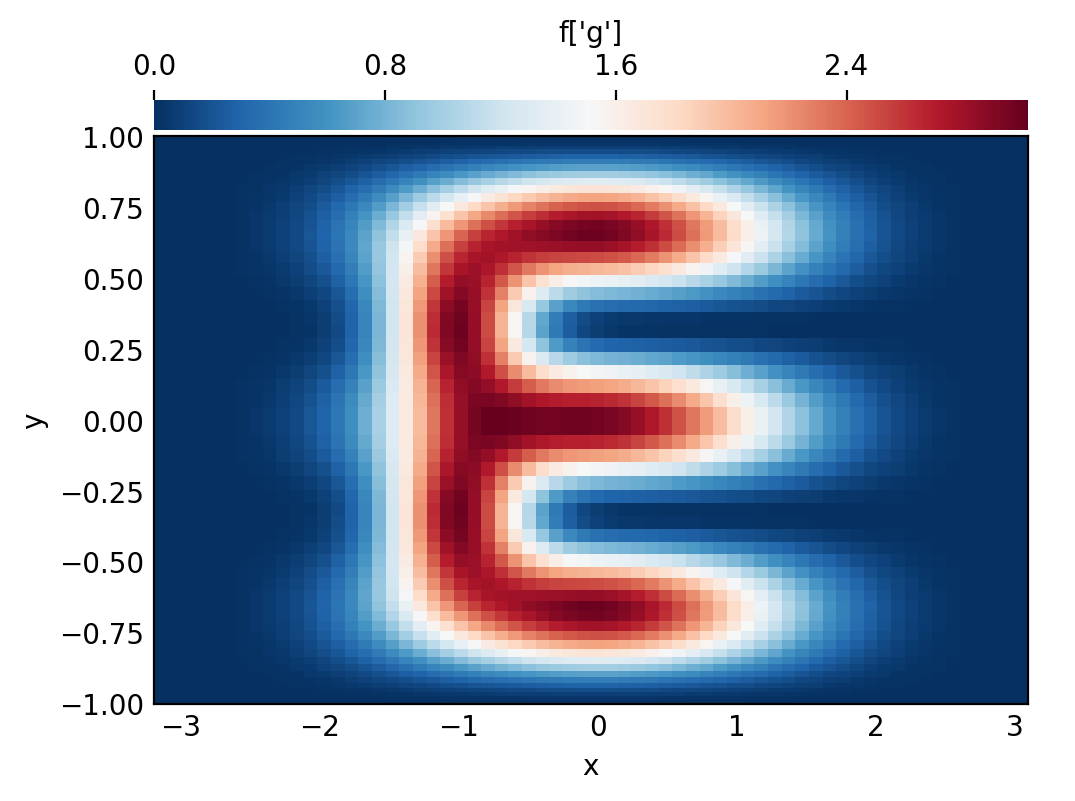

In [13]:
# Set scales back to 1 to build new grid data
f.set_scales(1)
f['g'] = 3*np.cos(1.5*np.pi*y)**2 * np.cos(x/2)**4 + 3*np.exp(-((2*x+2)**2 + (4*y+4/3)**2)) + 3*np.exp(-((2*x+2)**2 + (4*y-4/3)**2))

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

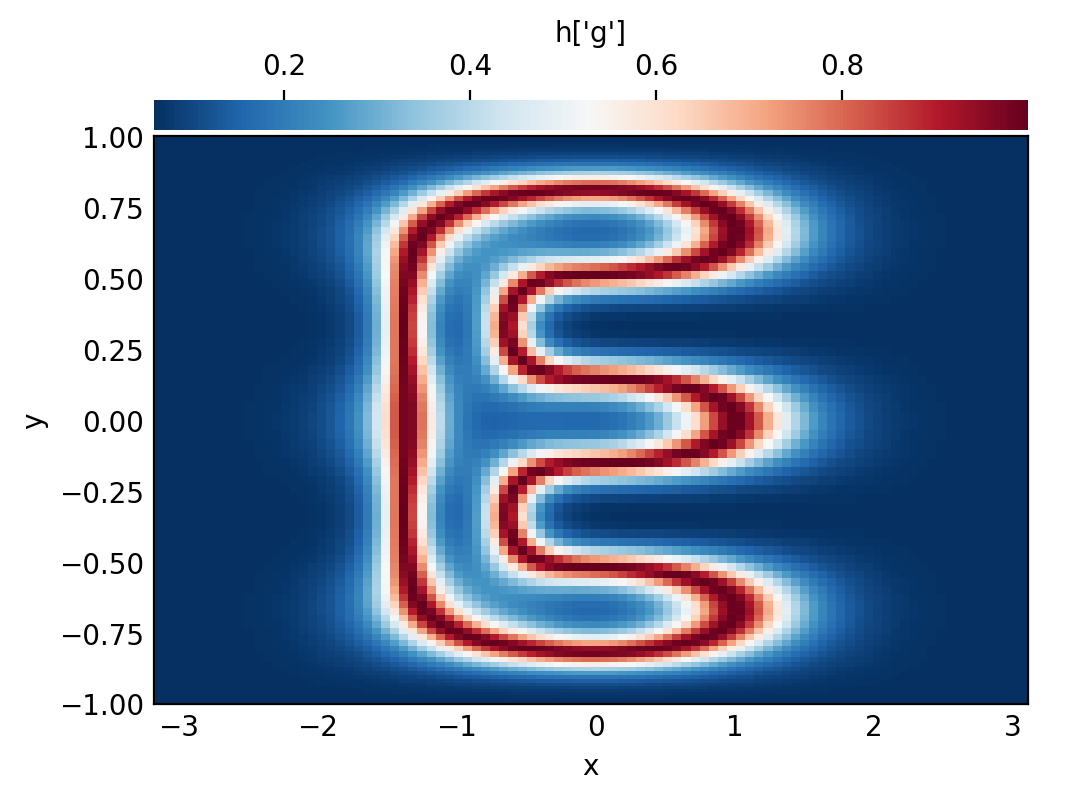

In [14]:
h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

### Differentiation, integration, interpolation

Operators are also used for differentiation, integration, and interpolation along each basis.
There are several ways to apply these operators to a field or operator expression.

**Basis operators:** First, the operators for a given dimension can be accessed through the `Differentiate`, `Integrate`, and `Interpolate` methods of the corresponding basis object.

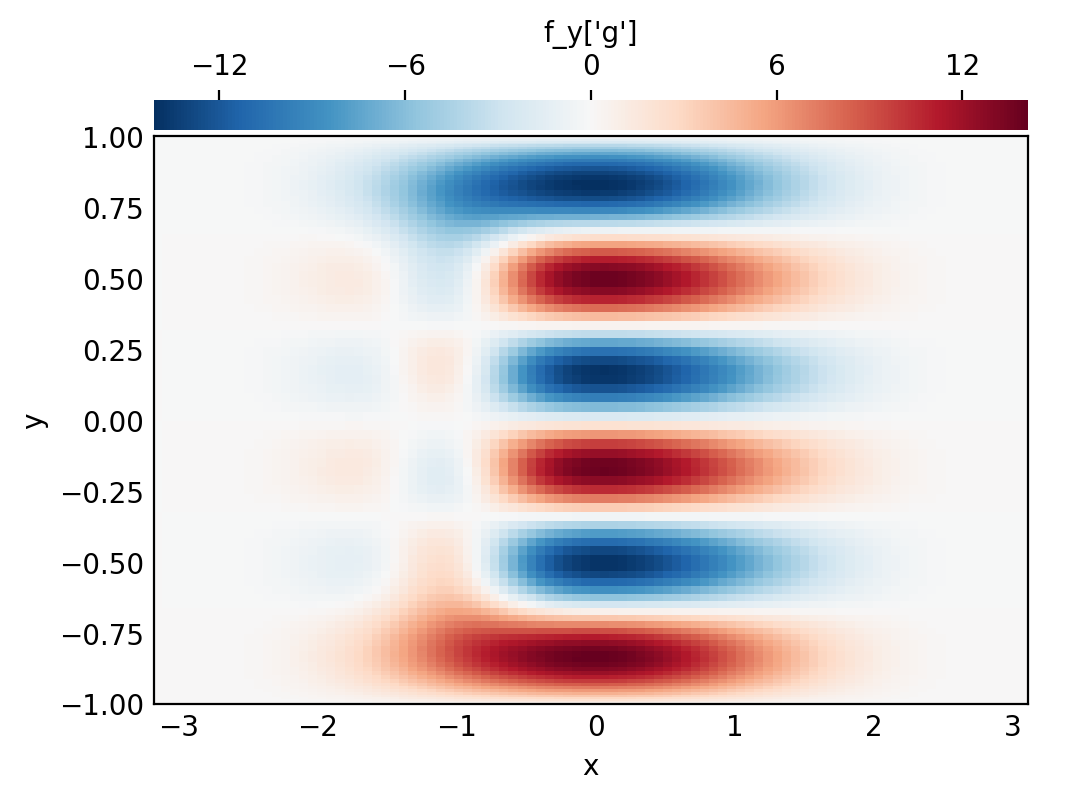

In [15]:
# Basis operators
f_y_op = ybasis.Differentiate(f)
f_yint_op = ybasis.Integrate(f)
f_y0_op = ybasis.Interpolate(f, position=0)

# Plot f_y
f_y = f_y_op.evaluate()
f_y['g']
plot_bot_2d(f_y, title="f_y['g']", figkw=figkw);

**Operator factories:** Second, more general "factory" interfaces are available through the `operators` module.
These factories provide a simple interface for composing the underlying basis operators in multiple dimensions.
The `operators.differentiate` factory allows us to easily construct higher-order and mixed derivatives involving different bases.
The `operators.integrate` and `operators.interpolate` factories allow us to integrate/interpolate along multiple axes, as well.

In [16]:
# Operator factories
f_xxyy_op = de.operators.differentiate(f, x=2, y=2)
f_int_op = de.operators.integrate(f, 'x', 'y')
f_00_op = de.operators.interpolate(f, x=0, y=0)

# See structure of f_int_op
print('f_int_op:', f_int_op)
print()

# Print total integral
# The result is a constant field, so we can print its value at any grid point
f_int = f_int_op.evaluate()
print('Total integral of f:', f_int['g'][0,0])

f_int_op: integ_y(integ_x(f))

Total integral of f: 9.424586589055345


**Field methods**: Finally, the `differentiate`, `integrate`, and `interpolate` field methods provide short-cuts for building and evaluating these operations, directly returning the resulting fields.

In [17]:
# Field methods
fxxyy = f.differentiate(x=2, y=2)
total_int_f = f.integrate('x', 'y')
f00 = f.interpolate(x=0, y=0)

# Print point interpolation
# The result is a constant field, so we can print its value at any grid point
print('f(x=0, y=0):', f00['g'][0,0])

f(x=0, y=0): 3.0185735210880122
